# Fine-tune


## ImageNet
ImageNet 是一个计算机视觉系统识别项目，是目前世界上最大的图像识别数据库，由斯坦福大学组织建立，大约有 1500 万张图片，2.2 万中类别，其中 ISLVRC 作为其子集是学术界中使用最为广泛的公开数据集，一共有 1281167 张图片作为训练集，50000 张图片作为验证集，一共是 1000 分类，是目前测试网络性能的标杆。

我们说的这个数据集有什么用呢？我们又不关心这个数据集，但是对于我们自己的问题，我们有没有办法借助 ImageNet 中的数据集来提升模型效果，比如我们要做一个猫狗分类器，但是我们现在只有几百张图片，肯定不够，ImageNet 中有很多关于猫狗的图片，我们如果能够把这些图片拿过来训练，不就能够提升模型性能了吗？

但是这种做法太麻烦了，从 ImageNet 中寻找这些图片就很困难，如果做另外一个问题又要去找新的图片，所以直接找图片并不靠谱，那么有没有办法能够让我们不去找这些图片，又能使用这些图片呢？

非常简单，我们可以使用在 ImageNet 上训练好的网路，然后把这个网络在放到我们自己的数据集上进行训练不就好了。这个方法就叫做微调，这十分形象，相当于把一个已经很厉害的模型再微调到我们自己的数据集上来，也可称为迁移学习。

迁移学习的方法非常简单，将预训练的模型导入，然后将最后的分类全连接层换成适合我们自己问题的全连接层，然后开始训练，可以固定卷积层的参数，也可以不固定进行训练，最后能够非常有效的得到结果

pytorch 一直为我们内置了前面我们讲过的那些著名网络的预训练模型，不需要我们自己去 ImageNet 上训练了，模型都在 `torchvision.models` 里面，比如我们想使用预训练的 50 层 resnet，就可以用 `torchvision.models.resnet50(pretrained=True)` 来得到

下面我们用一个例子来演示一些微调

In [1]:
import sys
sys.path.append('..')

import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder

### Visualize images

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

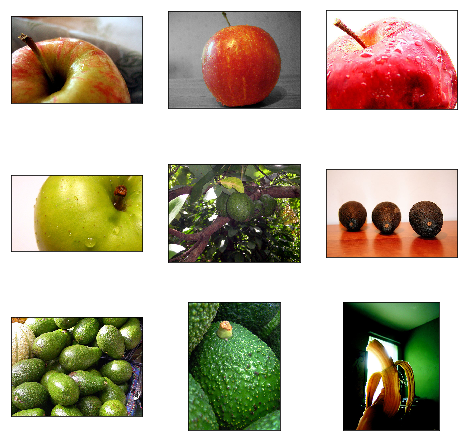

In [3]:
root_path = '/home/yang/dataset/imagenet/fruits/train/'
im_list = [os.path.join(root_path, 'apple', i) for i in os.listdir(root_path + 'apple')[:4]]
im_list += [os.path.join(root_path, 'avocado', i) for i in os.listdir(root_path + 'avocado')[:4]]
im_list += [os.path.join(root_path, 'banana', i) for i in os.listdir(root_path + 'banana')[:4]]
im_list += [os.path.join(root_path, 'kiwi', i) for i in os.listdir(root_path + 'kiwi')[:4]]
im_list += [os.path.join(root_path, 'watermelon', i) for i in os.listdir(root_path + 'watermelon')[:5]]

nrows = 3
ncols = 3
figsize = (8, 8)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(Image.open(im_list[nrows*i+j]))
        figs[i][j].axes.get_xaxis().set_visible(False)
        figs[i][j].axes.get_yaxis().set_visible(False)
plt.show()

In [4]:
# 定义数据预处理
train_tf = tfs.Compose([
    tfs.RandomResizedCrop(224),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 使用 ImageNet 的均值和方差
])

valid_tf = tfs.Compose([
    #tfs.Resize(256),
    tfs.CenterCrop(224),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# 使用 ImageFolder 定义数据集
train_set = ImageFolder('/home/yang/dataset/imagenet/fruits/train/', train_tf)
valid_set = ImageFolder('/home/yang/dataset/imagenet/fruits/val/', valid_tf)
# 使用 DataLoader 定义迭代器
train_data = DataLoader(train_set, 64, True, num_workers=4)
valid_data = DataLoader(valid_set, 8, False, num_workers=4)

In [6]:
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        # Normal convolution block followed by Batchnorm (CONV_3x3-->BN-->Relu)
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        # Depthwise convolution block (CONV_BLK_3x3-->BN-->Relu-->CONV_1x1-->BN-->Relu)
        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [7]:
model = MobileNet()
#print(model)
model = torch.nn.DataParallel(model).cuda()

In [8]:
params = torch.load('model_best.pth.tar')['state_dict']

In [9]:
model.load_state_dict(params)

In [ ]:
print(model)

# 打出第一层的权重
#print(model.conv1.weight)

In [10]:
# 将最后的全连接层改成二分类
#model.fc = nn.Linear(2048, 2)
model.fc = nn.Linear(2048, 5)
#model.fc = nn.Linear(2048, 2)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

In [12]:
from utils import train
train(model, train_data, valid_data, 30, optimizer, criterion)

Epoch 0. Train Loss: 5.300039, Train Acc: 0.140854, Valid Loss: 3.811271, Valid Acc: 0.189103, Time 00:00:13
Epoch 1. Train Loss: 2.425943, Train Acc: 0.500057, Valid Loss: 2.269520, Valid Acc: 0.451923, Time 00:00:14
Epoch 2. Train Loss: 1.605063, Train Acc: 0.616300, Valid Loss: 1.488357, Valid Acc: 0.596154, Time 00:00:14
Epoch 3. Train Loss: 1.197166, Train Acc: 0.673707, Valid Loss: 1.168612, Valid Acc: 0.682692, Time 00:00:14
Epoch 4. Train Loss: 1.044851, Train Acc: 0.692537, Valid Loss: 1.002823, Valid Acc: 0.692308, Time 00:00:14
Epoch 5. Train Loss: 0.908261, Train Acc: 0.718807, Valid Loss: 0.883386, Valid Acc: 0.669872, Time 00:00:14
Epoch 6. Train Loss: 0.845120, Train Acc: 0.730369, Valid Loss: 0.813628, Valid Acc: 0.698718, Time 00:00:14
Epoch 7. Train Loss: 0.826443, Train Acc: 0.730540, Valid Loss: 0.734148, Valid Acc: 0.727564, Time 00:00:14
Epoch 8. Train Loss: 0.778312, Train Acc: 0.750343, Valid Loss: 0.698603, Valid Acc: 0.727564, Time 00:00:14
Epoch 9. Train Loss

### 保存模型

In [13]:
torch.save(model.state_dict(), "mobienet_30e.pth.tar")

可视化预测的结果

In [14]:
model = model.eval() # 将网络改为预测模式

读一张本地数据库的图片

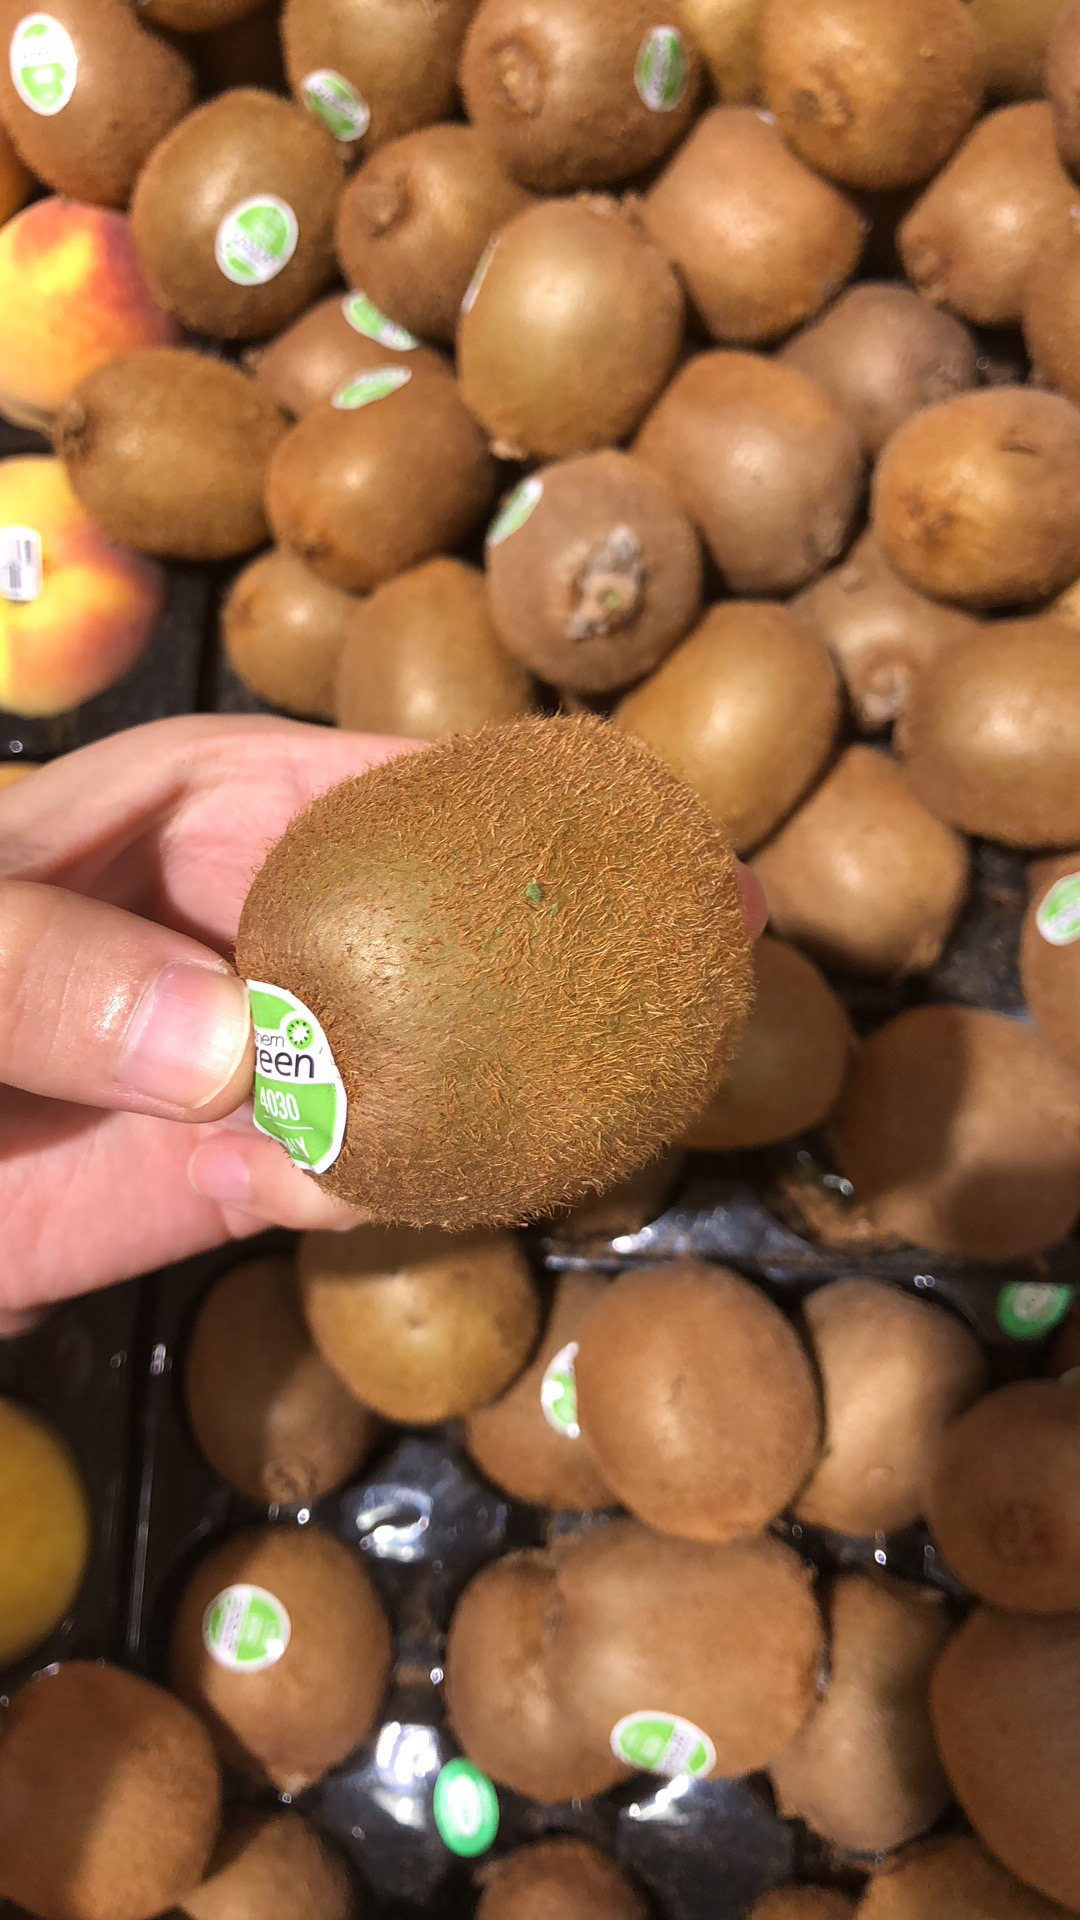

In [15]:
im1 = Image.open('/home/yang/dataset/imagenet/fruits/val/kiwi/756419172.jpg')
im1

In [16]:
im = valid_tf(im1) # 做数据预处理
out = model(Variable(im.unsqueeze(0)).cuda())
pred_label = out.max(1)[1].data[0]
print('predict label: {}'.format(train_set.classes[pred_label]))

predict label: kiwi
